
# ilSNe MST Demo — standardized magnification → λ, and stacking

This notebook demonstrates the current capabilities of the `ilsne` package:
- **Pivoted SN model**: work in terms of an apparent magnitude at a **pivot redshift** (H0-free).
- **Per-lens λ inference**: analytic marginalization over the pivot magnitude `m_p` with a Gaussian prior (e.g., Pantheon+).
- **Microlensing scatter models**: constant, radius-dependent, or CSV profile; propagate into the likelihood.
- **Stacking**: combine multiple lens posteriors.
- **Sensitivity sweeps**: explore the impact of microlensing assumptions on λ constraints.

**Science context (from WFS 1.1.3–1.1.4):** standardized magnification with SNe Ia **breaks the mass-sheet degeneracy (MSD)** and, when combined with **time-delay distances** from slSNe, enables a **~1% H0** measurement for Roman HLTDS-scale yields.



## 0) Setup

Run the following cell to import `ilsne`. If you're running this from the repo, it will add the repo path automatically.


In [ ]:

import sys, os, importlib, pathlib
repo_root_guess = pathlib.Path.cwd()

candidates = [
    repo_root_guess,
    repo_root_guess / "src",
    repo_root_guess.parent,
    repo_root_guess.parent / "src",
    pathlib.Path("src"),
]

slsim_candidates = [
    pathlib.Path.cwd() / "slsim-main",
    pathlib.Path.cwd().parent / "slsim-main",
    pathlib.Path("data/slsim_repo") / "slsim-main",
]
for sp in slsim_candidates:
    if (sp / "slsim" / "__init__.py").exists():
        sys.path.insert(0, str(sp))

try:
    import slsim  # noqa: F401
    print("slsim import OK (using", getattr(slsim, "__version__", "local"), ")")
except Exception as e:
    print("slsim not importable here:", e, "-- If running locally, install or add path to slsim.")

for p in candidates:
    try_path = p / "ilsne" / "__init__.py"
    if try_path.exists():
        sys.path.insert(0, str(p))
        break

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, List

# NumPy compatibility: ilsne uses np.trapezoid; patch if missing (old NumPy)
if not hasattr(np, "trapezoid"):
    np.trapezoid = np.trapz  # type: ignore[attr-defined]

import ilsne
from ilsne.pivot import FlatLCDM, m_sn_from_pivot, predict_unlensed_mag
from ilsne.magnification import LensedSN, LensDataset, infer_lambda_for_lens
from ilsne.io import lens_from_dataframe
from ilsne.microlens import sigma_micro_constant, sigma_micro_parametric, load_sigma_micro_from_csv
from ilsne.stacking import product_stack_common_lambda
from ilsne.viz import plot_lambda_posterior
from ilsne.slsim_yields import SurveyConfig, synthesize_yields
from ilsne.roman_interface import load_hltds_stub, to_survey_config

print("ilsne version:", getattr(ilsne, "__version__", "local"))
try:
    print("ilsne path:", ilsne.__file__)
except Exception:
    pass

# Optional: live Pantheon+ pivot via hierArc
mp_from_hierarc = None
try:
    from ilsne.hierarc_glue import PantheonPivotBlock
    mp_from_hierarc = PantheonPivotBlock
except Exception:
    mp_from_hierarc = None

try:
    from tqdm.auto import tqdm
except Exception:
    def tqdm(x, **k): return x

RNG_SEED = 42
np.random.seed(RNG_SEED)


slsim import OK (using 0.1.0 )
ilsne version: local
ilsne path: /Users/tztang/Documents/GitHub/ilSNe/src/ilsne/__init__.py


/Users/tztang/Documents/GitHub/ilSNe/src/ilsne/slsim_glue.py:83: SyntaxWarning: invalid escape sequence '\s'
  Pivot magnitude prior :math:`m_p \sim \mathcal{N}(\mu,\sigma)` [mag].



## 1) Cosmology, pivot, and prior for `m_p`

We **anchor** the absolute scale in an apparent magnitude at a chosen pivot redshift `z_pivot`:
\[
m_{\rm th}(z) = m_p + [\mu(z) - \mu(z_{\rm pivot})] .
\]

For this demo we assume a Pantheon+-like **Gaussian prior** on `m_p` with mean `mp_mean` and width `mp_sigma` (mag).


In [ ]:

cosmo = FlatLCDM(H0=70.0, Omega_m=0.3)
z_pivot = 0.1

def get_mp_prior(z_anchor: float) -> Tuple[float, float]:
    """
    Get (mp_mean, mp_sigma). Try hierArc Pantheon+ first; else fall back
    to an indicative Pantheon-like value.
    """
    if mp_from_hierarc is not None:
        try:
            block = mp_from_hierarc(z_anchor=z_anchor)
            mu, sig = block.fit_pivot_mean_std()
            print(f"Using Pantheon+ mp prior: {mu:.3f} +/- {sig:.3f} at z={z_anchor}")
            return float(mu), float(sig)
        except Exception as e:
            print("[warn] hierArc pivot prior failed; falling back:", e)
    return 18.966, 0.008

mp_mean, mp_sigma = get_mp_prior(z_pivot)


Using Pantheon+ mp prior: 18.954 +/- 0.004 at z=0.1



### 2) Build yields with **SLSim** (or ilsne's adapter fallback)

We use the Roman helper to get a cadence → `SurveyConfig`, then call
`ilsne.slsim_yields.synthesize_yields`. This will use a **native SLSim hook**
if available (preferred), else fall back to the in-repo adapter.

We then **explicitly set** a microlensing model per scenario to ensure the
two cases differ, and we **avoid double-counting** by folding σ_micro into
`sigma_m` when passing to the likelihood.


In [3]:

# Roman-like cadence → SurveyConfig
cad = load_hltds_stub()
survey = to_survey_config(cad)  # SurveyConfig(name, epochs, days_between, depths)
# Optional LOS config for native SLSim (ignored by fallback adapter)
survey.slsim = {"los": {"enable": True, "nonlinear": True, "nonlinear_h5": "data/joint_distributions_sigma8_0.825.h5"}}

# Define two microlensing scenarios:
#   Scenario A (blue): constant microlensing scatter
micro_const = {"kind": "const", "sigma": 0.02}          # 0.02 mag
#   Scenario B (orange): radial-dependent microlensing scatter
micro_rdep  = {"kind": "rdep", "a": 0.01, "b": 0.02}    # σ_micro = a + b * R_arcsec

def build_il_catalog(n_sn: int,
                     survey_cfg: SurveyConfig,
                     micro_model: dict,
                     seed: int = RNG_SEED) -> pd.DataFrame:
    """
    Build a standardized ilSN catalog using synthesize_yields (SLSim-backed if available).

    IMPORTANT:
    - We override σ_micro per the provided `micro_model` so the two scenarios
      (const vs R-dependent) are actually different.
    - We keep only `is_il` rows (single-image, intermediate-lensed SNe).
    """
    # Use synthesize_yields — this will call SLSim hook if available
    df = synthesize_yields(
        n_sn=n_sn, survey=survey_cfg, cosmo=cosmo,
        z_pivot=z_pivot, mp_mean=mp_mean, mp_sigma=mp_sigma,
        sigma_int=0.10, sigma_model=0.05, seed=seed, verbose=False,
    )

    # Keep only intermediate-lensed SNe
    if "is_il" in df.columns:
        df = df[df["is_il"]].copy()

    # Explicit microlensing assignment per scenario
    if micro_model.get("kind", "const") == "const":
        sig = float(micro_model.get("sigma", 0.0))
        df["sigma_micro_mag"] = sig
    else:
        a = float(micro_model.get("a", 0.01))
        b = float(micro_model.get("b", 0.02))
        # Ensure R_arcsec exists
        if "R_arcsec" not in df.columns:
            raise ValueError("Catalog missing R_arcsec for radial microlensing model.")
        df["sigma_micro_mag"] = a + b * df["R_arcsec"].values

    # Sanity check for required columns (from ilsne schema)
    need_cols = ["z_sn","R_arcsec","mu_fid","m_obs","sigma_int_mag","sigma_model_mag","sigma_micro_mag"]
    missing = [c for c in need_cols if c not in df.columns]
    if missing:
        raise ValueError(f"Catalog missing columns: {missing}")
    return df.reset_index(drop=True)

# Generate larger catalogs once; later we slice the first N rows
N_DRAW = 600
df_blue = build_il_catalog(N_DRAW, survey, micro_const, seed=123)
df_orng = build_il_catalog(N_DRAW, survey, micro_rdep,  seed=456)

print("blue df columns:", sorted(df_blue.columns)[:10], "… n=", len(df_blue))
print("orange df columns:", sorted(df_orng.columns)[:10], "… n=", len(df_orng))


blue df columns: ['R_arcsec', 'filters_hit', 'gamma1_ext', 'gamma2_ext', 'gamma_macro', 'image_id', 'is_il', 'is_sl', 'kappa_ext', 'kappa_macro'] … n= 600
orange df columns: ['R_arcsec', 'filters_hit', 'gamma1_ext', 'gamma2_ext', 'gamma_macro', 'image_id', 'is_il', 'is_sl', 'kappa_ext', 'kappa_macro'] … n= 600



### 3) Convert a catalog slice to a single-lens dataset with N ilSN

We **combine** uncertainties in quadrature to form `sigma_m`, **including**
σ_micro here. In the likelihood we set `sigma_micro_included_in_sigma_m=True`
and `sigma_int=0.0` to avoid double-counting.


In [4]:

def lens_from_df_slice(df_slice: pd.DataFrame, name: str) -> LensDataset:
    sne: List[LensedSN] = []
    for _, row in df_slice.iterrows():
        sigma_m = float(np.sqrt(
            float(row.get("sigma_int_mag", 0.0))**2 +
            float(row.get("sigma_model_mag", 0.0))**2 +
            float(row.get("sigma_micro_mag", 0.0))**2
        ))
        sne.append(
            LensedSN(
                z=float(row["z_sn"]),
                mu_model=float(row.get("mu_model", row["mu_fid"])),
                m_obs=float(row["m_obs"]),
                sigma_m=sigma_m,
                R_arcsec=float(row["R_arcsec"]),
            )
        )
    return LensDataset(name=name, sne=sne)



### 4) Scan N and compute fractional λ precision σ(λ)/⟨λ⟩

(This is a proxy for how many ilSN we need to bring MSD under control.)
We avoid σ_micro double counting by setting `sigma_micro_included_in_sigma_m=True`.


blue-const: sweeping N:   0%|          | 0/14 [00:00<?, ?N/s]

orange-rdep: sweeping N:   0%|          | 0/14 [00:00<?, ?N/s]

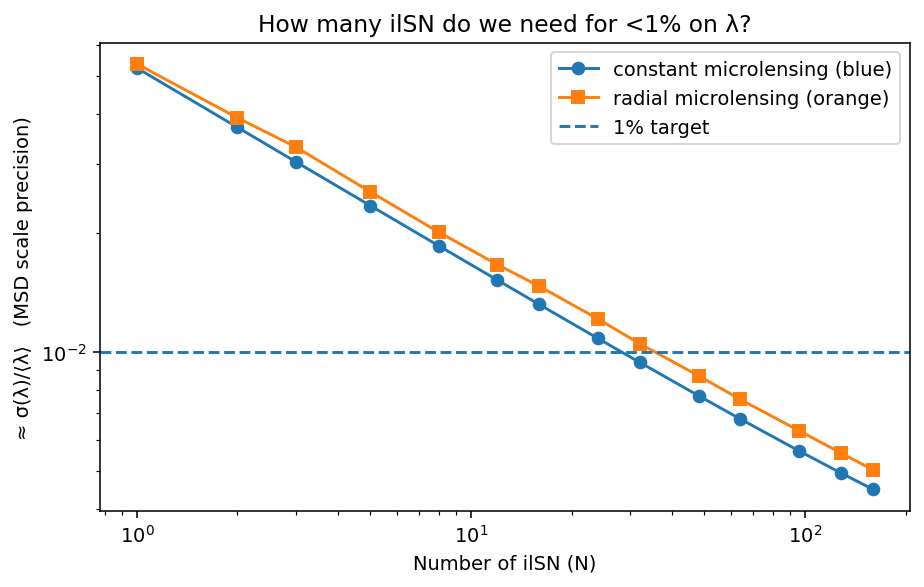

[result] N_1% (const micro): 32
[result] N_1% (radial micro): 48


In [5]:

scan_N = [1, 2, 3, 5, 8, 12, 16, 24, 32, 48, 64, 96, 128, 160]

def frac_sigma_lambda_vs_N(df: pd.DataFrame, label: str) -> Tuple[np.ndarray, np.ndarray, List[dict]]:
    xs, ys, posts = [], [], []
    for N in tqdm(scan_N, desc=f"{label}: sweeping N", unit="N"):
        sub = df.iloc[:N].copy()
        lens = lens_from_df_slice(sub, f"{label}-N{N}")
        res = infer_lambda_for_lens(
            lens,
            cosmo=cosmo,
            z_pivot=z_pivot,
            mp_mean=mp_mean,
            mp_sigma=mp_sigma,
            lam_grid=(0.6, 1.4, 2001),
            sigma_micro_fn=None,
            sigma_int=0.0,
            sigma_micro_included_in_sigma_m=True,
        )
        xs.append(N)
        ys.append(res["lam_std"] / res["lam_mean"])
        posts.append(res)
    return np.array(xs), np.array(ys), posts

x_b, y_b, posts_b = frac_sigma_lambda_vs_N(df_blue, "blue-const")
x_o, y_o, posts_o = frac_sigma_lambda_vs_N(df_orng, "orange-rdep")

plt.figure(figsize=(6.7, 4.3), dpi=140)
plt.plot(x_b, y_b, marker="o", label="constant microlensing (blue)")
plt.plot(x_o, y_o, marker="s", label="radial microlensing (orange)")
plt.axhline(0.01, linestyle="--", label="1% target")
plt.xscale("log"); plt.yscale("log")
plt.xlabel("Number of ilSN (N)")
plt.ylabel("≈ σ(λ)/⟨λ⟩   (MSD scale precision)")
plt.title("How many ilSN do we need for <1% on λ?")
plt.legend(); plt.tight_layout(); plt.show()

def min_N_for_target(xs, ys, thr=0.01):
    ok = [int(x) for x, y in zip(xs, ys) if y <= thr]
    return min(ok) if ok else None

print("[result] N_1% (const micro):",  min_N_for_target(x_b, y_b, 0.01))
print("[result] N_1% (radial micro):", min_N_for_target(x_o, y_o, 0.01))



### 5) Common-λ stacking (existing) vs. hierarchical-λ (optional)

We preserve your simple Gaussian approx summaries and EB shrinkage as an optional comparison.


In [6]:

import math
import numpy as np

def hierarchical_lambda_summary(means: np.ndarray, stds: np.ndarray, max_iter: int = 200, tol: float = 1e-8):
    s2 = stds**2
    tau2 = max(0.0, float(np.var(means) - np.mean(s2)))
    for _ in tqdm(range(max_iter), desc="Hierarchical λ iterations", unit="iter"):
        w = 1.0 / (s2 + tau2 + 1e-30)
        mu = np.sum(w * means) / np.sum(w)
        numer = max(0.0, np.sum(w * (means - mu)**2) / np.sum(w) - np.sum(w * s2) / np.sum(w))
        new_tau2 = max(0.0, numer)
        if abs(new_tau2 - tau2) < tol * (1.0 + tau2):
            tau2 = new_tau2
            break
        tau2 = new_tau2
    mu_var = 1.0 / np.sum(1.0 / (s2 + tau2 + 1e-30))
    return dict(mu_lambda=mu, sigma_mu=math.sqrt(mu_var), tau=math.sqrt(tau2))

def summaries_from_catalog(df: pd.DataFrame, chunk: int) -> Tuple[np.ndarray, np.ndarray]:
    means, stds = [], []
    K = len(df) // chunk
    for k in tqdm(range(K), desc="Summaries from catalog", unit="chunk"):
        sub = df.iloc[k*chunk:(k+1)*chunk]
        post = infer_lambda_for_lens(
            lens_from_df_slice(sub, f"lens-{k}"),
            cosmo=cosmo,
            z_pivot=z_pivot,
            mp_mean=mp_mean,
            mp_sigma=mp_sigma,
            lam_grid=(0.6, 1.4, 1601),
            sigma_micro_fn=None,
            sigma_int=0.0,
            sigma_micro_included_in_sigma_m=True,
        )
        means.append(post["lam_mean"])
        stds.append(post["lam_std"])
    return np.array(means), np.array(stds)

chunkN = 16
m_b, s_b = summaries_from_catalog(df_blue, chunk=chunkN)
m_o, s_o = summaries_from_catalog(df_orng, chunk=chunkN)
hier_b = hierarchical_lambda_summary(m_b, s_b)
hier_o = hierarchical_lambda_summary(m_o, s_o)
print("[hier] const micro:   mu_lambda=%.5f  sigma_mu=%.5f  tau=%.5f" % (hier_b["mu_lambda"], hier_b["sigma_mu"], hier_b["tau"]))
print("[hier] radial micro:  mu_lambda=%.5f  sigma_mu=%.5f  tau=%.5f" % (hier_o["mu_lambda"], hier_o["sigma_mu"], hier_o["tau"]))


Summaries from catalog:   0%|          | 0/37 [00:00<?, ?chunk/s]

Summaries from catalog:   0%|          | 0/37 [00:00<?, ?chunk/s]

Hierarchical λ iterations:   0%|          | 0/200 [00:00<?, ?iter/s]

Hierarchical λ iterations:   0%|          | 0/200 [00:00<?, ?iter/s]

[hier] const micro:   mu_lambda=1.00038  sigma_mu=0.00242  tau=0.00652
[hier] radial micro:  mu_lambda=0.99716  sigma_mu=0.00248  tau=0.00000



### 6) Optional: LOS κ_ext marginalization (fallback if SLSim LOS not present)

We push the λ posterior through λ_eff = λ / (1 − κ_ext). If SLSim LOS is
unavailable, we fall back to **N(0, 0.025)**.


In [7]:
# Use ilsne's first-class LOS APIs (no notebook glue)
from ilsne import posterior_lambda_intrinsic_from_total, sample_kappa_ext

# Optional: path to SLSim nonlinear LOS correction table.
NONLINEAR_H5 = "data/joint_distributions_sigma8_0.825.h5"

# Optionally estimate σ_κ from the catalog if provided; else use a conservative floor.
def estimate_sigma_kext(df: pd.DataFrame) -> float:
    if "kappa_ext" in df.columns:
        vals = np.asarray(df["kappa_ext"], float)
        s = float(np.nanstd(vals))
        if np.isfinite(s) and s > 1e-6:
            return s
    return 0.025


In [8]:
def choose_post_by_N(posts: List[dict], N: int) -> dict:
    idx = scan_N.index(N)
    return posts[idx]

# Choose the posteriors (unchanged)
post32_b = choose_post_by_N(posts_b, 32)   # "blue" micro model
post32_o = choose_post_by_N(posts_o, 32)   # "orange" micro model

z_l_32 = 0.4
z_s_32 = 0.9

# (A) If you want λ_tot (recommended for stacking): keep per-lens posteriors as-is
#     and only apply the τ-floor in your hierarchical combo later.
print("[λ_tot] blue N=32:   lam=%.5f ± %.5f" % (post32_b["lam_mean"], post32_b["lam_std"]))
print("[λ_tot] orange N=32: lam=%.5f ± %.5f" % (post32_o["lam_mean"], post32_o["lam_std"]))

# (B) If you explicitly want λ_int for a demonstration, map λ_tot → λ_int via ilsne.los_posterior:
sig_k_b = estimate_sigma_kext(df_blue)
sig_k_o = estimate_sigma_kext(df_orng)
lam_b, pdf_b = posterior_lambda_intrinsic_from_total(
    post32_b["lam_grid"], post32_b["posterior"], z_l=z_l_32, z_s=z_s_32,
    nsamp=4000, sigma_kext=sig_k_b, nonlinear_h5=NONLINEAR_H5
)
lam_o, pdf_o = posterior_lambda_intrinsic_from_total(
    post32_o["lam_grid"], post32_o["posterior"], z_l=z_l_32, z_s=z_s_32,
    nsamp=4000, sigma_kext=sig_k_o, nonlinear_h5=NONLINEAR_H5
)

mean_b = float(np.trapezoid(lam_b * pdf_b, lam_b)); std_b = float(np.sqrt(np.trapezoid((lam_b - mean_b)**2 * pdf_b, lam_b)))
mean_o = float(np.trapezoid(lam_o * pdf_o, lam_o)); std_o = float(np.sqrt(np.trapezoid((lam_o - mean_o)**2 * pdf_o, lam_o)))

print("[λ_int] blue N=32:   lam=%.5f ± %.5f  (from λ_tot + κ_ext)" % (mean_b, std_b))
print("[λ_int] orange N=32: lam=%.5f ± %.5f  (from λ_tot + κ_ext)" % (mean_o, std_o))


[λ_tot] blue N=32:   lam=0.99128 ± 0.00933
[λ_tot] orange N=32: lam=0.99545 ± 0.01044
[λ_int] blue N=32:   lam=0.99214 ± 0.02676  (from λ_tot + κ_ext)
[λ_int] orange N=32: lam=0.99646 ± 0.02714  (from λ_tot + κ_ext)
